In [1]:
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review

def read_data(file):
    '''
    Read each file into a list of strings.
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on',
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    return list(words)


def load_and_shuffle_data():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = "Data/pos"
    neg_path = "Data/neg"

    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)

    review = pos_review + neg_review
    random.shuffle(review)
    return review

# Taken from http://web.stanford.edu/class/cs221/ Assignment #2 Support Code
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale


In [2]:
data = load_and_shuffle_data()

## Question 6

In [3]:
#Create bag of words function
def bag_of_words_func(words):
    """
    Inputs:
    words: (list) a list of words
    
    Output:
    bag_of_words: (dictionary) Key: Word in words - Value: Count of Word in words
    """
    bag_of_words = {}
    #Exclude the last character as it is the label we need to predict
    for word in words[:-1]:
        bag_of_words[word] = bag_of_words.get(word,0) + 1
   
    #Return our bag of words
    return bag_of_words
    

## Question 7

In [4]:
#Grab the first 1500 Reviews / Labels for training
X_train = [bag_of_words_func(f) for f in data[:1500]]
y_train = [f[-1] for f in data[:1500]]

#Grab 500 more for Testing
X_test = [bag_of_words_func(f) for f in data[1500:2000]]
y_test = [f[-1] for f in data[1500:2000]]

## Question 8

In [5]:
def pegasos(x,y, lambda_reg, total_epochs):
    """
    Input:
    x: (dictionary) review data that has been manipulated into sparse dictionary representation
    y: (list) label values of ith position of data at x_i
    lambda_reg
    total_epochs: (int):  
    
    Output:
    w: dictionary of key value pairs, key: word in review, value: float describing the weight of prediction
    """
    
    #Initialize helper variables
    w = dict()
    epoch, t = 0, 0
    
    while epoch < total_epochs:
        for review in range(len(x)):
            
            #Update counter variable
            t += 1
            #Update step size
            step_size_t = 1/(lambda_reg*t)
            
            #Scale w variables
            increment(w, -step_size_t*lambda_reg, w)
            
            #If we have a missclassification, subtract the second portion of the gradient
            if y[review]*dotProduct(w,x[review]) < 1:
                increment(w, step_size_t*y[review], x[review])
        #Increment epoch counter variable
        epoch += 1     
        
    return w

In [6]:
def fast_pegasos_algo(x,y,lambda_reg,total_epochs):
    """
    Input:
    x: (dictionary) review data that has been manipulated into sparse dictionary representation
    y: (list) label values of ith position of data at x_i
    lambda_reg
    total_epochs: (int):  
    
    Output:
    w: dictionary of key value pairs, key: word in review, value: float describing the weight of prediction
    """
    
    #Initialize helper variables
    W = dict()
    epoch, t, s = 0, 1, 1
    
    while epoch < total_epochs:
        for review in range(len(x)):
            
            #Update counter variable
            t += 1
            #Update step size
            step_size_t = 1/(lambda_reg*t)
            
            #Update s
            s += (s * lambda_reg * -step_size_t)
            #If we have a missclassification, subtract the second portion of the gradient
            if y[review]*dotProduct(W,x[review])*s < 1:
                increment(W, (1/s)*step_size_t*y[review], x[review])
        #Increment epoch counter variable
        epoch += 1     
    W.update((x,y*s) for x,y in W.items())   
    return W

## Problem 10

In [7]:
lambda_reg = .1
epochs = 6

In [8]:
#Time test each approach
start = time.time()
w_slow = pegasos(X_train,y_train,lambda_reg, epochs)
end = time.time()
print('Slow pegasos algorithm run speed:', end-start)

start = time.time()
w_fast = fast_pegasos_algo(X_train,y_train,lambda_reg, epochs)
end = time.time()
print('Fast pegasos algorithm run speed:', end-start)

Slow pegasos algorithm run speed: 44.98774600028992
Fast pegasos algorithm run speed: 0.7436118125915527


## Problem 11

In [9]:
def classification_error(x,y,w):
    total_error = 0
    
    #Iterate over data
    for row in range(len(x)):
        #Get prediction
        if dotProduct(x[row],w)<0:
            y_hat = -1
        else:
            y_hat = 1
        
        if y_hat != y[row]:
            total_error += 1
    return total_error / len(y)

In [10]:
print('Slow loss:', classification_error(X_test,y_test,w_slow) , 'Fast loss:',classification_error(X_test,y_test,w_fast))

Slow loss: 0.304 Fast loss: 0.364


## Problem 12

In [ ]:
error_list = list()
lambda_list = list()
lambda_regs = np.logspace(-3,-1,num=20)
for lambda_reg in lambda_regs:
    w_fast = fast_pegasos_algo(X_train,y_train, lambda_reg, 50)
    error_list.append(classification_error(X_test,y_test,w_fast))
    lambda_list.append(lambda_reg)

In [ ]:
min_error_lambda = lambda_list[error_list.index(min(error_list))]

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(lambda_list,error_list)
plt.xscale('log')
plt.title('Percentage Test Error by Variable Lambda')

## Min error is achieved at $Percent \ Loss = 15.6\% $ , with $\lambda= 0.007228703350949573$

## Problem 13

In [12]:
#Get w weight dictionary
lambda_reg = .007228703350949573
w_fast = fast_pegasos_algo(X_train,y_train, lambda_reg, 50)

In [14]:
score_list = []
sentences = []
true_label = y_test
predicted_label = []
prediction_result = []
index_list = []
y_hat = None
#Iterate over data
for row in range(len(X_test)):
    #Get prediction score
    score = dotProduct(X_test[row],w_fast)
    #Define Prediction
    if score <0:
        y_hat = -1
    else:
        y_hat = 1
    #Check Prediction
    if y_hat != y_test[row]:
        result = 'Wrong'
    else:
        result = 'Correct'
    #Append Score, Y_hat prediction, prediction result, and sentence
    predicted_label.append(y_hat)
    score_list.append(score)
    prediction_result.append(result)
    sentences.append(' '.join(X_test[row].keys()))
    index_list.append(row)

In [15]:
data = [sentences,score_list,predicted_label,y_test,prediction_result,index_list]
columns = dict(enumerate(['Sentence','Score','Predicted Label','True Label','Prediction Result','Index']))
df = pd.DataFrame(data=data)
df = df.T
df.rename(columns=columns, inplace=True)
df['Bin'] = pd.qcut(df['Score'],5, labels=False)

In [16]:
class_list = ['High-Conf Pos Review','Low-Conf Pos Review',
              'Very Low Confidence Predictions','Low-Conf Neg Review','High-Conf Neg Review']

high_conf_pos = df[(df['Bin']==4) & (df['Prediction Result']=='Wrong')]
low_conf_pos = df[(df['Bin']==3) & (df['Prediction Result']=='Wrong')]
middle_ground = df[(df['Bin']==2) & (df['Prediction Result']=='Wrong')]
low_conf_neg = df[(df['Bin']==1) & (df['Prediction Result']=='Wrong')]
high_conf_neg = df[(df['Bin']==0) & (df['Prediction Result']=='Wrong')]

high_conf_pos_acc = len(high_conf_pos) / len(df[df['Bin']==4])
low_conf_pos_acc =  len(low_conf_pos) / len(df[df['Bin']==3])
middle_ground_acc =  len(middle_ground) / len(df[df['Bin']==2])
low_conf_neg_acc =  len(low_conf_neg) / len(df[df['Bin']==1])
high_conf_neg_acc =  len(high_conf_neg) / len(df[df['Bin']==0])

percentage_error_arr = [high_conf_pos_acc,low_conf_pos_acc,
                        middle_ground_acc,low_conf_neg_acc,high_conf_neg_acc] 

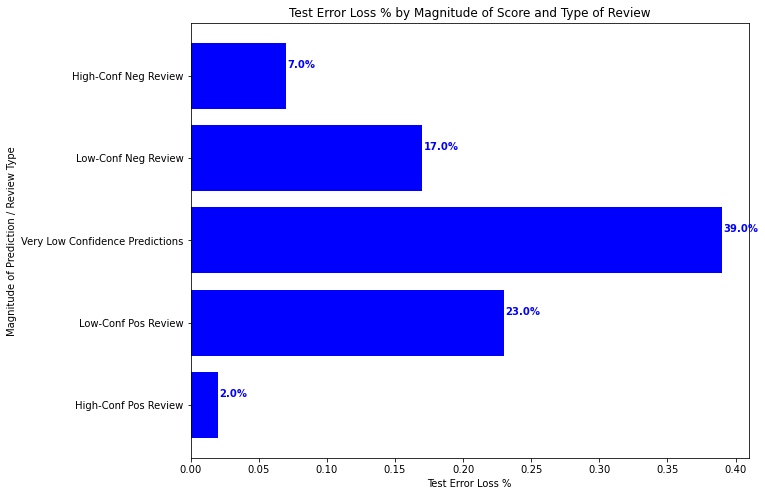

In [17]:
x = class_list
y = percentage_error_arr

fig, ax = plt.subplots(figsize=(10,8))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y,color="blue")
ax.set_yticks(ind)
ax.set_yticklabels(x, minor=False)
plt.title('Test Error Loss % by Magnitude of Score and Type of Review')
plt.xlabel('Test Error Loss %')
plt.ylabel('Magnitude of Prediction / Review Type')      
#plt.show()
for i, v in enumerate(y):
    ax.text(v+.001, i + .1, str(np.round(v*100,2))+'%', color='blue', fontweight='bold')

## Commentary:
There appears to be a strong correlation between higher magnitude scores and accuracy. Both Positive and Negative predictions that were made with strong confidence had a very low test error loss rate, at 2% and 7% respectively. Interestingly, low confidence positive predictions had less error (15%) than their Low Confidence Negative predictions (17%) error. Very low confidence predictions performed the worst, with an error of 37%. The "Very Low confidence Predictions" are defined as the middle quintile, with score values centered around 0. We can infer that the model did not know how to properly classify these examples, but did have some idea, as if it guessed randomly we would expect an error of 50%, however the actual error was 37%. 

## Problem 14

In [18]:
high_conf_wrong_prediction = df[(df['Bin']==4) & (df['Prediction Result']=='Wrong')]
high_conf_wrong_prediction = high_conf_wrong_prediction.iloc[0,:]

In [19]:
word_list = []
count_list = []
weight_list = []
score_list = []
product_list = []
abs_value_list = []
for k, v in X_train[high_conf_wrong_prediction['Index']].items():
    word_list.append(k)
    if k in w_fast.keys():
        weight_list.append(w_fast[k])
    count_list.append(v)

In [20]:
#Look at greatest impact on score by Abs Value of x_i * w_i
data = [word_list,count_list,weight_list]
columns = dict(enumerate(['Word','Count','Weight']))
df1 = pd.DataFrame(data=data)
df1 = df1.T
df1.rename(columns=columns, inplace=True)
df1['Product (x_i * w_i)'] = df1['Weight']*df1['Count']
df1['Abs Val of Product'] = df1['Product (x_i * w_i)'].apply(abs)
df1.sort_values(by='Abs Val of Product',ascending=False,inplace=True)
df1.head(20)

,Word,Count,Weight,Product (x_i * w_i),Abs Val of Product
18,and,11,0.169692,1.866608,1.866608
0,american,5,0.265604,1.328021,1.328021
2,2,5,-0.236093,-1.180463,1.180463
123,nothing,2,-0.468496,-0.936993,0.936993
92,have,3,-0.29696,-0.890881,0.890881
53,any,2,-0.407629,-0.815258,0.815258
67,it,7,0.105135,0.735945,0.735945
192,also,2,0.354139,0.708278,0.708278
144,most,3,0.230559,0.691678,0.691678
76,well,2,0.339383,0.678766,0.678766


In [21]:
#Look at least impactful words most frequent words
df1.tail(10)

,Word,Count,Weight,Product (x_i * w_i),Abs Val of Product
167,overseas,1,-0.003689,-0.003689,3.688948e-03
50,discomfort,1,0.003689,0.003689,3.688948e-03
169,student,1,-0.001844,-0.001844,1.844474e-03
87,ian,1,-0.001844,-0.001844,1.844474e-03
10,mostly,1,-0.001844,-0.001844,1.844474e-03
151,raging,1,0.001844,0.001844,1.844474e-03
3,is,14,0.0,0.0,4.817226e-15
98,seem,1,-0.0,-0.0,2.573078e-16
240,jim's,1,-0.0,-0.0,5.835847e-17
241,wellmeaning,1,-0.0,-0.0,2.804238e-17


In [22]:
middle_ground_prediction = df[(df['Bin']==3) & (df['Prediction Result']=='Wrong')]
middle_ground_prediction = middle_ground_prediction.iloc[0,:]

In [23]:
word_list = []
count_list = []
weight_list = []
score_list = []
product_list = []
abs_value_list = []
for k, v in X_train[middle_ground_prediction['Index']].items():
    word_list.append(k)
    if k in w_fast.keys():
        weight_list.append(w_fast[k])
    count_list.append(v)

In [24]:
#Look at greatest impact on score by Abs Value of x_i * w_i
data = [word_list,count_list,weight_list]
columns = dict(enumerate(['Word','Count','Weight']))
df1 = pd.DataFrame(data=data)
df1 = df1.T
df1.rename(columns=columns, inplace=True)
df1['Product (x_i * w_i)'] = df1['Weight']*df1['Count']
df1['Abs Val of Product'] = df1['Product (x_i * w_i)'].apply(abs)
df1.sort_values(by='Abs Val of Product',ascending=False,inplace=True)
df1.head(20)

,Word,Count,Weight,Product (x_i * w_i),Abs Val of Product
30,and,15,0.169692,2.545374,2.545374
57,well,5,0.339383,1.696916,1.696916
77,have,3,-0.29696,-0.890881,0.890881
33,?,8,-0.095913,-0.767301,0.767301
21,he,3,0.237937,0.713811,0.713811
14,to,16,-0.044267,-0.708278,0.708278
129,job,2,0.330161,0.660322,0.660322
262,if,2,-0.328316,-0.656633,0.656633
222,great,2,0.315405,0.63081,0.630810
248,you,2,0.300649,0.601299,0.601299


In [25]:
df1.tail(10)

,Word,Count,Weight,Product (x_i * w_i),Abs Val of Product
274,nostalgic,1,-0.001844,-0.001844,1.844474e-03
37,giggle,1,0.001844,0.001844,1.844474e-03
137,fianc,1,-0.001844,-0.001844,1.844474e-03
215,smiles,1,0.001844,0.001844,1.844474e-03
68,not,1,-0.001844,-0.001844,1.844474e-03
44,is,5,0.0,0.0,1.720438e-15
73,mr,1,-0.0,-0.0,2.936871e-16
116,unnecessary,1,0.0,0.0,4.585308e-17
128,eponymous,1,0.0,0.0,2.614762e-17
127,hart,1,0.0,0.0,7.579021e-19


For both the incorrect predictions I looked at, each of them has the majority of their score contributed to words like "the","and","any","this",etc. which don't necessarily help understand the sentiment of any given text, as they are included in both positive and negative reviews. Conversely, rare words that appeared in these reviews had no contribution to the models output score, as the model had not seen these words in training and therefore did not have any weights associated with them. I wonder if we could do some feature engineering to account for these transitory words that help make the sentence gramatically correct while not contributing to the sentiment. We could potentially add a feature that encapsulates all of these words, or change the way we represent a text. Say, rather than store the count of each word, we use a boolean value. Or additionally, we add some sort of positional embedding making the words relate to one another in some specific sense.